# Goal:
In this document we are starting to add some classes to the sklearn module. For this I installed the dev sklearn and then linked it. We worked on two different issues. 


In [1]:
import sklearn

In [2]:
sklearn.__version__

'0.18.dev0'

In [3]:
from sklearn.feature_selection import RFE

# Issue 5656

**RFE doc should mention that the estimator can also have a feature_importances_attribute #5656**

https://github.com/scikit-learn/scikit-learn/issues/5656
Right now it is mentioned that RecursiveFeatureElimination works only when the estimator has a coef_ attribute. However, that is not the case.

The file name is feature_selection.py.

In [4]:
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
%matplotlib inline

/Users/hugobowne-anderson/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


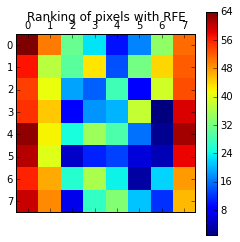

In [5]:
# Load the digits dataset
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))
y = digits.target

# Create the RFE object and rank each pixel
svc = SVC(kernel="linear", C=1)  #this is the estimator
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
rfe.fit(X, y)
ranking = rfe.ranking_.reshape(digits.images[0].shape)

# Plot pixel ranking
plt.matshow(ranking)
plt.colorbar()
plt.title("Ranking of pixels with RFE")


### Try with random forest 

In [6]:
from sklearn.ensemble import RandomForestClassifier as rf

In [7]:
forest = rf()
forest.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [8]:
forest.feature_importances_

array([ 0.        ,  0.00081691,  0.02211369,  0.01353519,  0.00616633,
        0.01587336,  0.0100655 ,  0.00076822,  0.        ,  0.00974496,
        0.02521875,  0.00649472,  0.01188353,  0.03289356,  0.00595334,
        0.00078691,  0.        ,  0.00777083,  0.02659677,  0.02551473,
        0.03869716,  0.04358525,  0.00603431,  0.00042167,  0.        ,
        0.01402531,  0.04644582,  0.02319976,  0.02878729,  0.02339061,
        0.02964136,  0.00011688,  0.        ,  0.01979946,  0.03102075,
        0.01216981,  0.03452998,  0.01638122,  0.01429145,  0.        ,
        0.        ,  0.01879703,  0.04395886,  0.04905705,  0.02088377,
        0.02662221,  0.00848892,  0.        ,  0.        ,  0.00282653,
        0.01547007,  0.01430104,  0.01155239,  0.0317395 ,  0.02262063,
        0.0025436 ,  0.        ,  0.00248384,  0.01116474,  0.01380435,
        0.04066694,  0.02682775,  0.02819864,  0.00325672])

# Issue 5824 

*Working on this issue with Hugo Browne. *

The issue: Meta-estimators for multi-output learning https://github.com/scikit-learn/scikit-learn/issues/5824

I think it would be useful to have meta-estimators for turning a classifier or a regressor into a multi-output classifier or regressor. It's a recurrent pattern and I find myself reimplementing it every once in a while.

This is of course useful for estimators that don't have native multi-output support but even for those that have like RF, I find that estimating a model independently for each output sometimes works better.

Class names: MultiOutputClassifier and MultiOutputRegressor

In [26]:
import sys
sys.path.append('dev_multi/')
import array
import numpy as np
import warnings
import scipy.sparse as sp

from sklearn.base import BaseEstimator, ClassifierMixin, clone, is_classifier
from sklearn.base import MetaEstimatorMixin, is_regressor
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils import check_random_state
from sklearn.utils.validation import _num_samples
from sklearn.utils.validation import check_consistent_length
from sklearn.utils.validation import check_is_fitted
from sklearn.externals.joblib import Parallel
from sklearn.externals.joblib import delayed

import numpy as np

#from MultiOneVsRest import MultiOneVsRestClassifier

In [10]:
# Get the data from the digits and format it for test case. Subset for fast testing
# Load the digits dataset
digits = load_digits()
X = digits.images.reshape((len(digits.images), -1))[:100,:]
y = digits.target[:100]

# combine these to make a new thing
Y= np.vstack((y.T,y.T)).T

In [25]:
from sklearn.multiclass import OneVsRestClassifier

class MultiOneVsRestClassifier(BaseEstimator, ClassifierMixin, MetaEstimatorMixin):
    """This class fits a series of one-versus-all models to response matrix Y with n_samples and p
    labels on the predictor Matrix X with n_samples and m_feature variables. This allows for multiple 
    label classification. For each label (column in Y), a separate OneVsRestClassifier is fit. 
    See the base OneVsRestClassifier Class in sklearn.multiclass for more details.
    
    Parameters
    ----------
    estimator : estimator object
        An estimator object implementing `fit` and one of `decision_function`
        or `predict_proba`.
    n_jobs : int, optional, default: 1
        The number of jobs to use for the computation. If -1 all CPUs are used.
        If 1 is given, no parallel computing code is used at all, which is
        useful for debugging. For n_jobs below -1, (n_cpus + 1 + n_jobs) are
        used. Thus for n_jobs = -2, all CPUs but one are used.
        
        Note that parallel processing only occurs if there is multiple classes within each label. 
        It does each label in y in series.
        
        """
    
    def __init__(self, estimator, n_jobs=1):
        self.estimator = estimator
        self.n_jobs = n_jobs

    def fit(self, X, y):
        """Fit underlying estimators. Creates a dictionary of the estimators. 

        Parameters
        ----------
        X : (sparse) array-like, shape = [n_samples, n_features]
            Data.

        y : (sparse) array-like, shape = [n_samples, n_classes]
            Multi-class targets. An indicator matrix turns on multilabel
            classification.

        Returns
        -------
        self
        """

        # Calculate the number of classifiers
        num_y = y.shape[1]
        
        ## create a dictionary of estimators
        self.estimators_ ={}
        
        # intit OneVsRestClassfier
        ovr = OneVsRestClassifier(self.estimator,self.n_jobs)
        
        for i in range(num_y):
            self.estimators_[i] = ovr.fit(X,y[:, i])
            
        return self
    
    def predict(self, X):
        """Predict multi-class multi-label targets using a model trained for each label. 

        Parameters
        ----------
        X : (sparse) array-like, shape = [n_samples, n_features]
        Data.

        Returns
        -------
        y : dict of [(sparse) array-like], shape = {predictors: n_samples}
          or {predictors: [n_samples, n_classes], n_predictors}.
            Predicted multi-class targets across multiple predictors.
            Note:  entirely separate models are generated for each predictor.
        """
        # check to see if the fit has been performed
        check_is_fitted(self, 'estimators_')
        
        results = {}
        for label, model_ in self.estimators_.iteritems():
            results[label] = model_.predict( X)
        return(results)
    
    def predict_proba(self, X):
        """Probability estimates. This returns prediction probabilites for each class for each label in the form of 
        a dictionary. 
       
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
        Returns
        -------
        prob_dict (dict) A dictionary containing n_label sparse arrays with shape = [n_samples, n_classes]. 
            Each row in the array contains the the probability of the sample for each class in the model,
            where classes are ordered as they are in `self.classes_`.
        """
        # check to see whether the fit has occured. 
        check_is_fitted(self, 'estimators_')
        
        results ={}
        for label, model_ in self.estimators_.iteritems():
            results[label] = model_.predict_proba(X)
        return(results)
    
    @property
    def multilabel_(self):
        """returns a vector of whether each classifer is a  multilabel classifier in tuple for"""
        return [(label, model_.multilabel_) for label, model_ in self.estimators_.iteritems()]
    @property
    def classes_(self):
        return [(label, model_.label_binarizer_) for label, model_ in self.estimators_.iteritems()]
 

In [22]:

#M = MultiOneVsRestClassifier(forest, n_jobs = -1)

NameError: name 'BaseEstimator' is not defined

In [13]:
M.fit(X,Y)

MultiOneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
             n_jobs=-1)

In [14]:
probs = M.predict_proba(X)

In [15]:
f = M.estimators_[0]

In [16]:
f.label_binarizer_

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=True)

In [17]:
M.classes_

[(0, LabelBinarizer(neg_label=0, pos_label=1, sparse_output=True)),
 (1, LabelBinarizer(neg_label=0, pos_label=1, sparse_output=True))]